#[Tiny Llama](https://arxiv.org/pdf/2401.02385)

TinyLlama, an open-source small language model developed by Peiyuan Zhang, Guangtao Zeng, Tianduo Wang, and Wei Lu, distinguishes itself from its larger counterpart, Llama, by operating with reduced computational demands.

Despite having 1.1 billion parameters, this figure is modest compared to other LLMs with hundreds of billions or even trillions of parameters.


##Configurations and imports

Let's import everything we need for the execution!

**Remember to set the flags in the right way to execute everything you need**

In [ ]:
USE_PRETRAINED = True       # Set to False if you want to fine-tune the model and save it, otherwise it will be loaded the previous fine-tuned LoRA model
EXPORT_MODEL = False        # Set to True if you want to export the GGUF model
DOWNLOAD_BIOSENT = False    # Set to True if you want to download the biosentvec dataset to test the model
TEST_MODEL = True           # Set to True if you want to test the model
DOWNLOAD_DATASET = False    # Set to True if you want to download the huggingface dataset and re-split it (note that by doing it you will have a different split of the train-test)

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Tiny llama'
DATAS_PATH = '/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Datasets'
model_name = "unsloth/tinyllama-bnb-4bit"

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
from google.colab import drive

from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

import torch

from datasets import load_dataset
from datasets import Dataset

from trl import SFTTrainer

from transformers import TrainingArguments
from transformers.utils import logging

from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

from string import punctuation

from scipy.spatial import distance

from tqdm import tqdm

import numpy as np

import pandas as pd

import sys
import time
import os

import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [ ]:
if TEST_MODEL:
  !pip install bert-score
  from bert_score import BERTScorer

  !git clone https://github.com/epfml/sent2vec.git
  %cd sent2vec
  !make
  !pip install .
  import sent2vec

  sys.setrecursionlimit(4000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if DOWNLOAD_BIOSENT:
  os.chdir(f'{DATAS_PATH}')
  os.getcwd()
  !wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioSentVec_PubMed_MIMICIII-bigram_d700.bin

In [ ]:
os.chdir(f'{MODEL_PATH}')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP/project/Models/Tiny llama'

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Model definition

To accelerate the fine-tuning process of our model, we opted for a lightweight tool developed by the community: [Unsloth](https://github.com/unslothai/unsloth).

Unsloth works by overwriting some parts of the modeling code with optimized operations. By manually deriving backpropagation steps and rewriting all Pytorch modules into Triton kernels, Unsloth can both reduce memory usage and make fine-tuning faster.

Crucially, **accuracy degradation is 0%** with respect to normal QLoRA, because no approximations are made in the optimized code.

In [ ]:
max_seq_length = 4096   # We use RoPE Scaling to extend it to 4096 with Unsloth!
dtype = None            # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True     # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
if USE_PRETRAINED:
    #@title Loading finetuned models
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 2.0, it can be magically be extended to 4096!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Unsloth 2024.5 patched 22 layers with 22 QKV layers, 22 O layers and 22 MLP layers.


In [ ]:
if not USE_PRETRAINED:
  model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
  )


To speedup the tuning even more and decrease the needed computational power we used [LoRA](https://arxiv.org/abs/2106.09685). LoRA is a novel technique introduced by Microsoft researchers to deal with the problem of fine-tuning large-language models.

LoRA proposes freezing pre-trained model weights, which reduces the number of trainable parameters and GPU memory requirements.

In [ ]:
if not USE_PRETRAINED:
  model = FastLanguageModel.get_peft_model(
      model,
      r = 32,    #16 in previous implementation                    # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
      target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj",],
      lora_alpha = 32, #16 in previous implementation
      lora_dropout = 0,                                            # Currently only supports dropout = 0
      bias = "none",                                               # Currently only supports bias = "none"
      use_gradient_checkpointing = "unsloth",                          # We set `gradient_checkpointing=False` ONLY for TinyLlama since Unsloth saves tonnes of memory usage. @@@ IF YOU GET OUT OF MEMORY - set to True @@@
      random_state = 3407,
      use_rslora = False,                                          # We support rank stabilized LoRA
      loftq_config = None,                                         # And LoftQ
  )

Now, let's define the prompt used for tuning our model and create the function to map our data to this prompt.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass



## Dataset import
To maintain the integrity of model testing, we pre-saved the dataset split in a dataframe. This ensures that during testing, no training samples are utilized, thereby preserving the model evaluation process.

In [ ]:
if DOWNLOAD_DATASET:
  dataset_path = "medalpaca/medical_meadow_medical_flashcards"
  raw_dataset = load_dataset(dataset_path)
  dataset = raw_dataset["train"].train_test_split(test_size=0.2)
  train_dataset = dataset["train"]
  test_dataset = dataset["test"]
  if False:
    df_train = dataset["train"].to_pandas()
    df_test = dataset["test"].to_pandas()
    os.chdir(f'{DATAS_PATH}')
    os.getcwd()
    df_train.to_csv("train_split.csv", index=False)
    df_test.to_csv("test_split.csv", index=False)
    os.chdir(f'{MODEL_PATH}')
    os.getcwd()
else:
  os.chdir(f'{DATAS_PATH}')
  os.getcwd()
  test_dataset = Dataset.from_pandas(pd.read_csv('test_split.csv'))
  train_dataset = Dataset.from_pandas(pd.read_csv('train_split.csv'))
  os.chdir(f'{MODEL_PATH}')
  os.getcwd()

train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/27164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6791 [00:00<?, ? examples/s]

## Tuning the model
Now let's use Huggingface TRL's `SFTTrainer`!

In [ ]:
if not USE_PRETRAINED:
  logging.set_verbosity_info()

  training_args = TrainingArguments(
      per_device_train_batch_size = 8,
      gradient_accumulation_steps = 4,
      warmup_ratio = 0.1,
      num_train_epochs = 3,
      save_steps = 100,
      learning_rate = 2e-4,
      fp16 = not is_bfloat16_supported(),
      bf16 = is_bfloat16_supported(),
      #fp16 = not torch.cuda.is_bf16_supported(),
      #bf16 = torch.cuda.is_bf16_supported(),
      logging_steps = 1,
      optim = "adamw_8bit",
      weight_decay = 0.01,
      lr_scheduler_type = "linear",
      seed = 3407,
      output_dir = "outputs",
      overwrite_output_dir = True
  )

  trainer = SFTTrainer(
      model = model,
      tokenizer = tokenizer,
      train_dataset = train_dataset,
      dataset_text_field = "text",
      max_seq_length = max_seq_length,
      dataset_num_proc = 2,
      packing = False, # Packs short sequences together to save time!
      args = training_args,
  )

In [ ]:
if not USE_PRETRAINED:
  #@title Show current memory stats
  gpu_stats = torch.cuda.get_device_properties(0)
  start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
  max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
  print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
  print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
if not USE_PRETRAINED:
  if len(os.listdir("outputs")) <= 1:
    trainer_stats = trainer.train()
  else:
    trainer_stats = trainer.train(resume_from_checkpoint=True)

In [ ]:
if not USE_PRETRAINED:
  #@title Show final memory and time stats
  used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
  used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
  used_percentage = round(used_memory         /max_memory*100, 3)
  lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
  print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
  print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
  print(f"Peak reserved memory = {used_memory} GB.")
  print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
  print(f"Peak reserved memory % of max memory = {used_percentage} %.")
  print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

##Functions
Some useful functions!

The preprocess_sentence function is utilized to eliminate punctuation and stopwords from the input text.

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

The generate_answer function utilizes the input model to generate a response to the provided question.

In [ ]:
def generate_answer(question):
  # alpaca_prompt = Copied from above
  FastLanguageModel.for_inference(model) # Enable native 2x faster inference
  inputs = tokenizer(
  [
      alpaca_prompt.format(
          "Answer this question truthfully", # instruction
          question, # input
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
  tokenizer.batch_decode(outputs)
  predicted_answer = tokenizer.batch_decode(outputs[:, inputs['input_ids'].shape[1]:])[0]
  predicted_answer = predicted_answer[:(len(predicted_answer)-5)]
  return predicted_answer

## Inference
Let's run the model! You can change the instruction and input - leave the output blank!

 We can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Answer this question truthfully", # instruction
        "What is the PAP test?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Answer this question truthfully

### Input:
What is the PAP test?

### Response:
The PAP test is a diagnostic test used to detect the presence of pneumonia in patients with cystic fibrosis.</s>


##Testing

To evaluate the model is essential to establish metrics that evaluate the accuracy of a generated answer relative to the correct one. In our context, we have identified two key metrics: **BERTScore** and **Evaluation with Embedding**

We chose these metrics over more statistical ones because both BERTScores and embeddings take into account the contextual meaning of sentences when assessing their similarity, making them excellent choices for evaluating our models.

To expedite the evaluation process, a stopping criterion has been used. If, in the last 20 iterations of the for loop calculating the mean score, the mean does not change significantly, the execution stops, and the score is printed.

Additionally, the model has been evaluated for execution time in answering questions.

In [ ]:
index = 300
#@title Manual testing
real_answer = test_dataset[index]["output"]
generated_answer = generate_answer(test_dataset[index]["input"])
question = test_dataset[index]["input"]

print("Question: ", question)
print("Generated answer: ", generated_answer)
print("Real answer: ", real_answer)

Question:  What does it mean if the relative risk is less than 1 in relation to exposure and disease occurrence?
Generated answer:  If the relative risk is less than 1 in relation to exposure and disease occurrence, it means that there is a significant difference between the risk of disease occurrence and the risk of exposure to the disease
Real answer:  If the relative risk is less than 1, it means that exposure to a particular factor or variable is associated with a decreased occurrence of the disease in question. In other words, individuals who are exposed to the factor or variable are less likely to develop the disease than those who are not exposed. The relative risk is a measure of the strength of the association between exposure and disease occurrence, and a value less than 1 indicates a negative association.


###BioSentVec loading...

In [ ]:
if TEST_MODEL:
  model_path = f'{DATAS_PATH}/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
  testing_model = sent2vec.Sent2vecModel()

In [ ]:
if TEST_MODEL:
  def evaluate_answer(real, predicted):
    sentence_vector1 = testing_model.embed_sentence(preprocess_sentence(real))
    sentence_vector2 = testing_model.embed_sentence(preprocess_sentence(predicted))
    cosine_sim = 1 - distance.cosine(sentence_vector1[0], sentence_vector2[0])
    return cosine_sim

In [ ]:
if TEST_MODEL:
  try:
      testing_model.load_model(model_path)
  except Exception as e:
      print(e)
  print('model successfully loaded')

model successfully loaded


###BioSentVec score

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]
    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      score = evaluate_answer(real_answer, generated_answer)
      if i == 0:
        mean = score
      sum += score
      n_try += 1
      old_mean = mean
      mean = sum/n_try
      mean_list.append(mean)

      if abs(mean - old_mean) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: 0.6392995715141296 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: 0.7622046768665314 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: 0.7565935651461283 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: 0.8142030537128448 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: 0.8441580057144165 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: 0.8612397114435831 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: 0.8373740996633258 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: 0.852329708635807 
Last relevant mean change is 0 iteration ago


Iteration: 8, Mean: 0.868737518787384 
Last relevant mean change is 0 iteration ago


Iteration: 9, Mean: 0.863528949022293 
Last relevant mean change is 0 iteration ago


Iteration: 10, Mean: 0.8643241849812594 
Last relevant mean change is 1 iteration ago


Iteration: 11, Mean: 0.8401952485243479 
Last

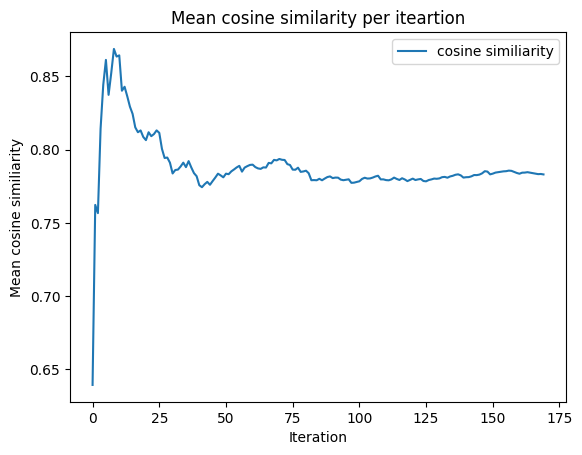

In [ ]:
if TEST_MODEL:
  plt.plot(mean_list, label='cosine similiarity')
  plt.ylabel('Mean cosine similiarity')
  plt.xlabel('Iteration')
  plt.title("Mean cosine similarity per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'the average cosine similarity is: {mean}')

the average cosine similarity is: 0.7830379782354131


###BERTScore

In [ ]:
# Initialize the BERTScorer object
if TEST_MODEL:
  scorer = BERTScorer(lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if TEST_MODEL:
  sum = [0, 0, 0]
  n_try = 0
  mean_score_list = []
  patience = 20
  k = 0
  for i in range(len(test_dataset)):
    real_answer = test_dataset[i]["output"]
    question = test_dataset[i]["input"]

    generated_answer = generate_answer(question)
    if (generated_answer) is not None and (real_answer) is not None:
      P, R, F1 = scorer.score([generated_answer], [real_answer])
      score = [float(P), float(R), float(F1)]
      if i == 0:
        mean_score = score
      sum = [x + y for x, y in zip(sum, score)]
      n_try += 1
      old_mean = mean_score
      mean_score = [(x / n_try) for x in sum]
      mean_score_list.append(mean_score)

      if abs(mean_score[0] - old_mean[0]) < 0.001 and abs(mean_score[1] - old_mean[1]) < 0.001 and abs(mean_score[2] - old_mean[2]) < 0.001:
        k += 1
        if k == patience:
          print(f'Early stopping at iteration: {i}')
          break
      else:
        k=0
      print(f'Iteration: {i}, Mean: {mean_score} \nLast relevant mean change is {k} iteration ago\n\n')

Iteration: 0, Mean: [0.8928676247596741, 0.8216316103935242, 0.855769693851471] 
Last relevant mean change is 1 iteration ago


Iteration: 1, Mean: [0.9125876128673553, 0.8656459152698517, 0.8883071839809418] 
Last relevant mean change is 0 iteration ago


Iteration: 2, Mean: [0.8905721505482992, 0.8618041674296061, 0.8756428162256876] 
Last relevant mean change is 0 iteration ago


Iteration: 3, Mean: [0.9146097302436829, 0.8900710195302963, 0.901922419667244] 
Last relevant mean change is 0 iteration ago


Iteration: 4, Mean: [0.9295998334884643, 0.9096210360527038, 0.9192759156227112] 
Last relevant mean change is 0 iteration ago


Iteration: 5, Mean: [0.9386492967605591, 0.9204460680484772, 0.9292652110258738] 
Last relevant mean change is 0 iteration ago


Iteration: 6, Mean: [0.9346323013305664, 0.9073369758469718, 0.9204673937388829] 
Last relevant mean change is 0 iteration ago


Iteration: 7, Mean: [0.9408787786960602, 0.9158875793218613, 0.9279280826449394] 
Last relevant mea

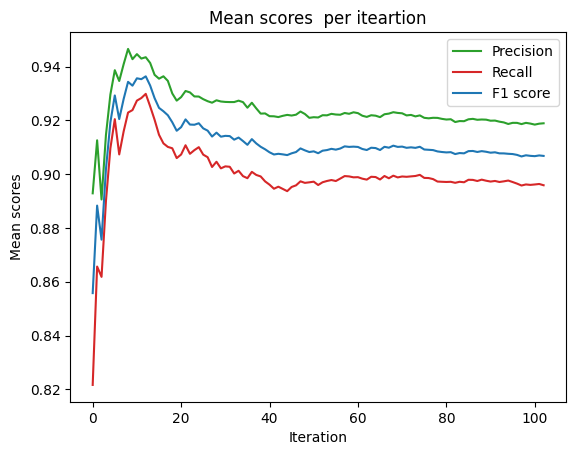

In [ ]:
if TEST_MODEL:
  plt.plot([mean_score[0] for score in mean_score_list], color='#2ca02c',label='Precision')
  plt.plot([mean_score[1] for score in mean_score_list], color='#d62728',label='Recall')
  plt.plot([mean_score[2] for score in mean_score_list],label='F1 score')

  plt.ylabel('Mean scores')
  plt.xlabel('Iteration')
  plt.title("Mean scores  per iteartion")
  plt.legend()
  plt.show()

In [ ]:
if TEST_MODEL:
  print("Precision: ", mean_score[0])
  print("Recall: ", mean_score[1])
  print("F1 score: ", mean_score[2])

Precision:  0.9189088824883248
Recall:  0.8958726565814713
F1 score:  0.9067789634454597


###Execution time

In [ ]:
if TEST_MODEL:
  sum = 0
  n_try = 0
  mean_time_list = []
  patience = 20
  k = 0
  for i in tqdm(range(200)):
    question = test_dataset[i]["input"]

    start = time.time()
    generated_answer = generate_answer(question)
    end = time.time()

    score_time = end-start
    if i == 0:
      mean_time = score_time
    sum += score_time
    n_try += 1
    old_mean_time = mean_time
    mean_time = sum/n_try
    mean_time_list.append(mean_time)

100%|██████████| 200/200 [08:07<00:00,  2.44s/it]


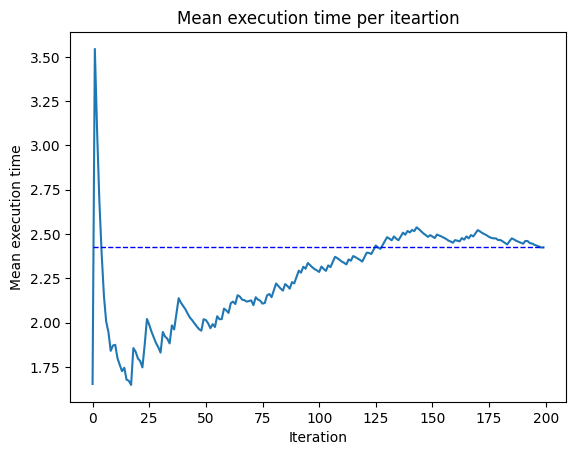

In [ ]:
if TEST_MODEL:
  plt.plot(mean_time_list)
  plt.plot([mean_time for i in mean_time_list], '--', color='blue', label='Mean', linewidth=1)
  plt.ylabel('Mean execution time')
  plt.xlabel('Iteration')
  plt.title("Mean execution time per iteartion")
  plt.show()

In [ ]:
if TEST_MODEL:
  print(f'The average execution time is: {mean_time}')

The average execution time is: 2.4346137964725494


## Saving
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.


In [ ]:
if not USE_PRETRAINED:
  model.save_pretrained("lora_model") # Local saving
  tokenizer.save_pretrained("lora_model")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--tinyllama-bnb-4bit/snapshots/82c9ac484c6a4191514431e172bf62c482e0a1b0/config.json
Model config LlamaConfig {
  "_name_or_path": "unsloth/tinyllama",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0

##GGUF / llama.cpp Conversion
Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods:
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
if EXPORT_MODEL:
  # Save to 8bit Q8_0
  if False: model.save_pretrained_gguf("model", tokenizer,)
  if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

  # Save to 16bit GGUF
  if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
  if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

  # Save to q4_k_m GGUF
  if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
  if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")